In [1]:
import numpy as np
import scipy.io as sio
from sklearn.metrics import mean_squared_error
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras import backend as K
import matplotlib.pyplot as plt
np.random.seed(1337)  # for reproducibility
%matplotlib inline

Using TensorFlow backend.


Text(0.5,0,'Youngs Modulus Value = \n0.085')

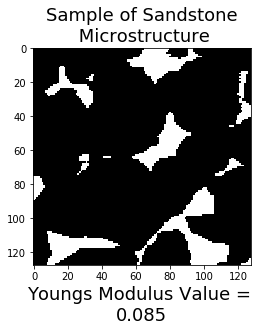

In [2]:
# input image dimensions
img_rows, img_cols = 128, 128
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (3, 3)

# Import the data
WB = np.array(sio.loadmat('sandstone_data.mat')['Data'])
Y_data = np.array(sio.loadmat('sandstone_data.mat')['L'])
# Normalize the data
X_data = np.reshape(WB,(len(WB),1,img_rows,img_cols))
Y_data = (Y_data-min(Y_data))/(max(Y_data)-min(Y_data))

# data splitting                         
X_train = X_data[:600]                  
Y_train = Y_data[:600]

X_val = X_data[600:700]
Y_val = Y_data[600:700]

X_test = X_data[700:]                  
Y_test = Y_data[700:]

# show image sample
axes = plt.gca()
plt.imshow(X_train[10].reshape(img_rows,img_cols),'gray')
axes.set_title('Sample of Sandstone\n Microstructure',fontsize=18)
axes.set_xlabel('Youngs Modulus Value = \n{:.2}'.format(Y_train[0][0]),fontsize=18)        

In [3]:
# Adjust data shape for different Keras version
if K.image_dim_ordering() == 'th':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_val = X_val.reshape(X_val.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
# Tensorflow only take float32 data type
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')

# print out the data information
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_val.shape[0], 'validate samples')
print(X_test.shape[0], 'test samples')

X_train shape: (600, 128, 128, 1)
600 train samples
100 validate samples
68 test samples


In [4]:
# CNN Model
model = Sequential()

# block 1
model.add(Convolution2D(24, (6, 6), padding='same', input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))

# block 2
model.add(Convolution2D(48, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))

# fully connected layers
model.add(Flatten())
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))
# model compile
model.compile(loss='mse', optimizer='adam', metrics=['mae'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 24)      888       
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 24)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 24)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 48)        10416     
_________________________________________________________________
activation_2 (Activation)    (None, 64, 64, 48)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 48)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 49152)             0         
__________

In [5]:
# train the model
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='min')
model.fit(X_train, Y_train, batch_size=50, epochs=100, verbose=1, validation_data=(X_val, Y_val),
          callbacks=[early_stop], initial_epoch=0)


Train on 600 samples, validate on 100 samples
Epoch 1/100
600/600 [==============================] - 17s 29ms/step - loss: 0.1625 - mean_absolute_error: 0.3272 - val_loss: 0.0594 - val_mean_absolute_error: 0.2103
Epoch 2/100
600/600 [==============================] - 16s 27ms/step - loss: 0.0537 - mean_absolute_error: 0.1999 - val_loss: 0.0484 - val_mean_absolute_error: 0.1914
Epoch 3/100
600/600 [==============================] - 16s 27ms/step - loss: 0.0215 - mean_absolute_error: 0.1198 - val_loss: 0.0070 - val_mean_absolute_error: 0.0671
Epoch 4/100
600/600 [==============================] - 15s 24ms/step - loss: 0.0051 - mean_absolute_error: 0.0551 - val_loss: 0.0031 - val_mean_absolute_error: 0.0433
Epoch 5/100
600/600 [==============================] - 15s 25ms/step - loss: 0.0018 - mean_absolute_error: 0.0331 - val_loss: 0.0016 - val_mean_absolute_error: 0.0324
Epoch 6/100
600/600 [==============================] - 15s 25ms/step - loss: 0.0011 - mean_absolute_error: 0.0252 - val

training mse: 0.0003691139357478827
testing mse: 0.0008954447495822719


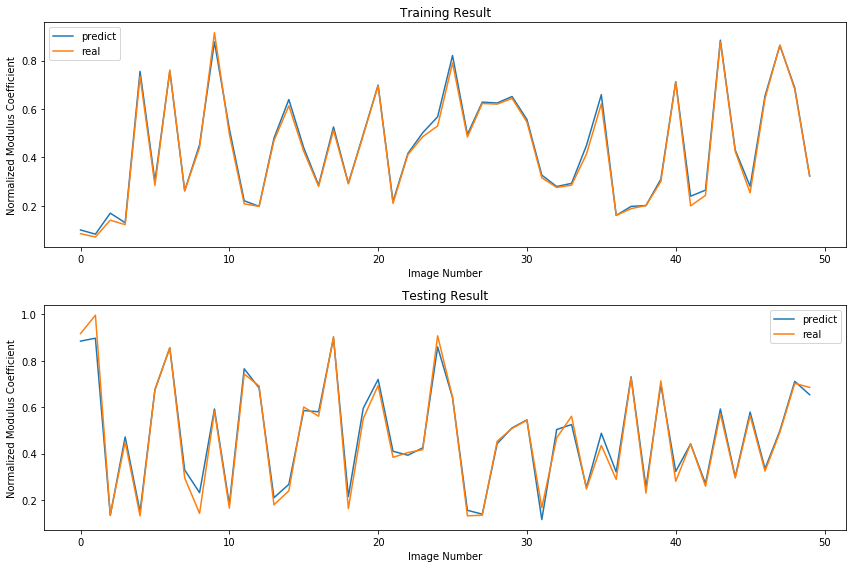

In [8]:
# the number of points to show as comparison
num_comp=50
x=np.arange(num_comp)

# define plot size
fig = plt.figure(figsize=(12,8))
ax1=fig.add_subplot(2,1,1)

# prediction value by training set
train_pred=model.predict(X_train)
print('training mse:', mean_squared_error(Y_train, train_pred))

ax1.plot(x,train_pred[0:num_comp], label='predict')
ax1.plot(x,Y_train[0:num_comp],label='real')
plt.legend()
ax1.set_title('Training Result')
ax1.set_xlabel('Image Number')
ax1.set_ylabel('Normalized Modulus Coefficient')


ax2=fig.add_subplot(2,1,2)

# prediction value by testing set
test_pred=model.predict(X_test)
print('testing mse:', mean_squared_error(Y_test, test_pred))

ax2.plot(x,test_pred[0:num_comp], label='predict')
ax2.plot(x,Y_test[0:num_comp],label='real')
plt.legend()
ax2.set_title('Testing Result')
ax2.set_xlabel('Image Number')
ax2.set_ylabel('Normalized Modulus Coefficient')

plt.tight_layout()

(0.0, 1.0)

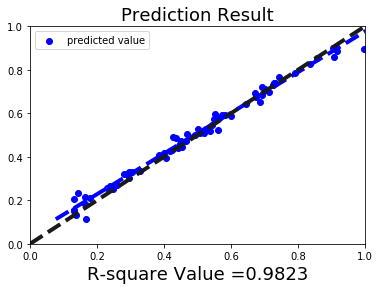

In [9]:
from sklearn.metrics import r2_score
plt.scatter(Y_test.reshape(-1),test_pred,label='predicted value',color='blue')
axes = plt.gca()
m, b = np.polyfit(Y_test.reshape(-1), test_pred, 1)
X_plot = np.linspace(axes.get_xlim()[0],axes.get_xlim()[1],100)
plt.plot(X_plot, m*X_plot + b, '--',color='blue',linewidth=4)

plt.plot([0, 1], [0, 1], ls="--", c=".1",linewidth=4)
plt.legend()
axes.set_title('Prediction Result',fontsize=18)
axes.set_xlabel('R-square Value ={:.4}'.format(r2_score(Y_test.reshape(-1), test_pred.reshape(-1))),fontsize=18)
plt.ylim(0.0,1.0)
plt.xlim(0.0,1.0)
